<a href="https://colab.research.google.com/github/roihanmufli/SentimentAnalysis/blob/main/skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install sastrawi

     |████████████████████████████████| 215kB 18.6MB/s 


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import normalize

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
### data mentah

data_mentah = pd.read_excel('/content/drive/MyDrive/skripsi/dataset/pelabelan_fix.xlsx')

In [ ]:
### Cek data mentah

top_5_mentah = data_mentah['Data Tweets'].head(6).values

print('Sebelum dibersihkan : ')
for x in top_5_mentah:
  print(x)

Sebelum dibersihkan : 
Sarannya bagus banget @smartfrenworld , mungkin harus saat nya ganti kartu perdana nih ke @Telkomsel https://t.co/hRIdnrlbQX
@Telkomsel @MenjengAnget @e100ss Klo tanya nmor hp mana yg sinyal telkomselnya jelek, jawabannya ya banyak org, mmgkin rata2 pake telkomsel dikampumg saya rata2 yg jd bahan pembicaraan adalah telkomsel mahal tapi No Sinyal
@MenjengAnget @Telkomsel @e100ss Namanya telkomsel harga selangit tapi SINYAL ANCURR, padahal di tengah kota besar, petunjuknya selalu refresh jaringan gitu trs, percuma sinyal tetep hoax n kalah sm jaringan kartu laen yg murah2, ya jwbannya gitu2 aja, ki
@MenjengAnget @Telkomsel @e100ss Ganti aja untuk paket datanya mbak, itu yang ini buat telpon saja
@Telkomsel Thrifty cuma berlaku 1x?
@Telkomsel min maksudnya revamp multisim itu gimana ya? Kuotanya bisa dipake di semua jam dan semua aplikasi gak? https://t.co/gRG36n0CZB


In [ ]:
### Read data

df = pd.read_excel('/content/drive/MyDrive/skripsi/dataset/data_telkomsel_fix.xlsx')


In [ ]:
data =pd.DataFrame(df)

data = data.drop(['No'],axis=1)


In [ ]:
data['Label'].value_counts().to_list()

[2214, 624]

In [ ]:
data['Label'].value_counts()

negatif    2214
positif     624
Name: Label, dtype: int64

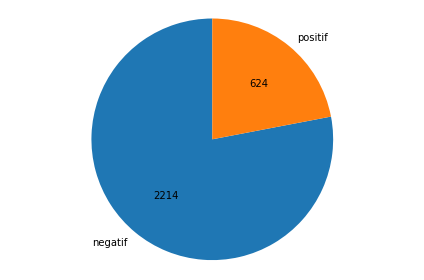

In [ ]:
def absolute_value(val):
    a  = int(np.round(val/100.*np.sum(sizes), 0))
    return a
sizes = data['Label'].value_counts().to_list()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['negatif','positif'], autopct=absolute_value,
        startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()


In [ ]:
data['Label'] = data['Label'].replace('negatif',0)
data['Label'] = data['Label'].replace('positif',1)

In [ ]:
#### Cleaning data

def strip_links(text):

    #text = text.replace('2g','twoji')
    #text = text.replace('2G','twoji')
    #text = text.replace('3g','triji')
    #text = text.replace('3G','triji')
    #text = text.replace('4g','forji')
    #text = text.replace('4G','forji')
    #text = text.replace('4G+','forjiplus')
    #text = text.replace('5g','fiveji')
    #text = text.replace('5G','fiveji')
    #text = text.replace('H+','hspaplus')
    #text = text.replace('IM3','IMtri')
    #text = text.replace(' 3 ', ' tri ')
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    
    for link in links:
        text = text.replace(link[0], ' ')
    return text


def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                result_word = ''.join(i for i in word if not i.isdigit())
                words.append(result_word)
    return ' '.join(words)

In [ ]:
#### Pembersihan Data


data['Data Tweets'] = [strip_all_entities(strip_links(t.encode("ascii", "ignore").strip().decode('ascii'))) for t in data['Data Tweets'].values]
data_mentah['Data Tweets'] = [strip_all_entities(strip_links(t.encode("ascii", "ignore").strip().decode('ascii'))) for t in data_mentah['Data Tweets'].values]


In [ ]:
for x in data_mentah['Data Tweets'].head(3):
  print(x)

Sarannya bagus banget mungkin harus saat nya ganti kartu perdana nih ke
Klo tanya nmor hp mana yg sinyal telkomselnya jelek jawabannya ya banyak org mmgkin rata pake telkomsel dikampumg saya rata yg jd bahan pembicaraan adalah telkomsel mahal tapi No Sinyal
Namanya telkomsel harga selangit tapi SINYAL ANCURR padahal di tengah kota besar petunjuknya selalu refresh jaringan gitu trs percuma sinyal tetep hoax n kalah sm jaringan kartu laen yg murah ya jwbannya gitu aja ki


In [ ]:
#### Case Folding

data['Data Tweets'] = data['Data Tweets'].apply(lambda x : x.lower())
data_mentah['Data Tweets'] = data_mentah['Data Tweets'].apply(lambda x : x.lower())

In [ ]:
for x in data_mentah['Data Tweets'].head(3):
  print(x)

sarannya bagus banget mungkin harus saat nya ganti kartu perdana nih ke
klo tanya nmor hp mana yg sinyal telkomselnya jelek jawabannya ya banyak org mmgkin rata pake telkomsel dikampumg saya rata yg jd bahan pembicaraan adalah telkomsel mahal tapi no sinyal
namanya telkomsel harga selangit tapi sinyal ancurr padahal di tengah kota besar petunjuknya selalu refresh jaringan gitu trs percuma sinyal tetep hoax n kalah sm jaringan kartu laen yg murah ya jwbannya gitu aja ki


In [ ]:
### Dictionary Colloquial Language

dictionary = {
    ' ancurr ' : ' hancur ',
    ' out ' : ' keluar ',
    'no network': 'tidak ada jaringan',
    ' turn of ' : ' mematikan ',
    ' turn off ' : ' mematikan ',
    ' turn on ' : ' menyalakan ',
    'pop up' : 'muncul',
    'no internet connection' : 'tidak ada jaringan internet',
    'no service' : 'tidak ada layanan',
    'no simcard' : 'tidak ada simcard',
    'incoming call' : 'panggilan masuk',
    ' ps ' : ' saat ',
    'klo' : 'kalau',
    'trs' : 'terus',
    'nmor': 'nomor',
    ' yg ' : ' yang ',
    ' org ' : ' orang ',
    ' orng ' : ' orang ',
    ' mmgkin ' : ' mungkin ',
    'pake ' : 'pakai ',
    ' pake ' : ' pakai ',
    ' jd ' : ' jadi ',
    ' sm ' : ' sama ',
    'laen' : 'lain',
    'jwban': 'jawaban',
    ' pls ' : ' pulsa ',
    'pls ' : 'pulsa ',
    ' pls' : ' pulsa',
    ' t-sel ' : ' telkomsel ',
    ' knp ' : ' kenapa ',
    ' bgt ' : ' banget ',
    ' knppp ' : ' kenapa ',
    ' tulong ' : ' tolong ',
    ' ampe ' : ' sampai ',
    ' ud ' : ' sudah ',
    'ud ' : 'sudah ',
    ' lbh ' : ' lebih ',
    ' dr ' : ' dari ',
    'kyk' : 'kayak',
    ' drtd ' : ' dari tadi ',
    ' drtdi ' : ' dari tadi ',
    ' pdhl ' : ' padahal ',
    ' erorr ' : ' eror ',
    ' krn ' : ' karena ',
    ' karna ' : ' karena ',
    ' berfikir ' : ' berpikir ',
    ' tgl ' : ' tanggal ',
    ' karo ' : ' sampai ',
    ' bru ' : ' baru ',
    ' cb ' : ' coba ',
    ' tp ' : ' tapi ',
    ' haddddaaah ' : ' hadah ',
    ' hufftt ' :' huft ',
    ' bettuuuulllll ' : ' betul ',
    ' buanyakkkkkkkk ' : ' banyak ',
    ' puarah ' : ' parah ',
    ' tsel ' : ' telkomsel ',
    ' pdhal ' : ' padahal ',
    ' sabi ' : ' bisa ',
    ' gx ' : ' enggak ',
    ' yslm ' : ' ya salam ',
    ' yslm' : ' ya salam',
    'yslm ' : 'ya salam ',
    ' ngirim ' : ' mengirim ',
    ' jg ' : ' juga ',
    ' nerima ' : ' menerima ',
    ' trobel ' : ' masalah ',
    'trobel ' : 'masalah ',
    ' trobel' : ' masalah',
    ' motong ' : ' memotong ',
    ' sampe ' : ' sampai ',
    ' hp ' : ' ponsel ',
    ' lahi ' : ' lagi ',
    ' ga ' : ' enggak ',
    ' gk ' : ' enggak ',
    ' ads ' : ' ada ',
    ' gpp ' : ' enggak apa apa ',
    ' hape ' : ' ponsel ',
    ' skrg ' : ' sekarang ',
    ' gak ' : ' enggak ',
    ' udeh ' : ' sudah ',
    ' yaa ' : ' ya ',
    ' utk ' : ' untuk ',
    ' ilangan ' : ' hilang ',
    ' ilang an ' : ' hilang ',
    ' ilang ' : ' hilang ',
    ' ilang' : ' hilang',
    ' ngga ' : ' enggak ',
    ' yahhh ' : ' ya ',
    ' kokgituuuu ' : ' kok begitu ',
    ' ajg ' : ' anjing ',
    ' ngabisin ' : ' menghabiskan ',
    'kalo' : 'kalau',
    ' telek com ' : ' telkomsel ',
    ' bln ' : ' bulan ',
    ' biadap ' : ' biadab ',
    ' ngisih ' : ' mengisi ',
    ' poto ' : ' foto ',
    'jumping' : 'loncat',
    ' wa ' : ' whatsapp ',
    ' munyer ' : ' putar ',
    ' maksut ' : ' maksud ',
    ' sy ' : ' saya ',
    ' tdk ' : ' tidak ',
    ' gakad ' : ' enggak ada ',
    ' gada ' : ' enggak ada ',
    ' gaada ' : ' enggak ada ',
    ' beginii ' : ' begini ',
    ' wahh ' : ' wah ',
    ' woah ' : ' woah ',
    ' ni ' : ' ini ',
    'signal' : 'sinyal',
    ' ko ' : ' kok ',
    ' kook ' : ' kok ',
    ' ngajar ' : ' mengajar ',
    'telokmsel' : ' telkomsel ',
    ' lg ' : ' lagi ',
    ' lgi ' : ' lagi ',
    ' provaider ' : ' provider ',
    ' tapu ' : ' tapi ',
    ' idieeee ' : ' idih ',
    ' bangeeeeetttttttttttt ' : ' banget ',
    ' responnyaaaaaaaaaaaa ' : ' responnya ',
    ' cmn ' : ' cuma ',
    ' abis ' : ' habis ',
    ' refrens ' : ' refresh ',
    ' tolo ' : ' tolong ',
    ' halooo ' : ' halo ',
    ' hallo ' : ' halo ',
    ' kab ' : ' kabupaten ',
    ' refres ' : ' refresh ',
    ' miiinnn ' : ' min ',
    ' dri ' : ' dari ',
    ' woiii ' : ' woi ',
    ' berlaggnan ' : ' berlangganan ',
    ' tmn ' : ' teman ',
    'sbener' : 'sebenar',
    ' ngebenerin ' : ' memperbaiki ',
    'perbaikin' : 'perbaiki',
    ' sinyak ' : ' sinyal ' ,
    ' krna ' : ' karena ',
    ' dgn ' : ' dengan ',
    ' dlm ' : ' dalam ',
    ' cm ' : ' cuma ',
    'cuman' : 'cuma',
    ' telp ' : ' telepon ',
    ' gimn ' : ' gimana ',
    ' gmn ' : ' gimana ',
    ' kenapaa ' : ' kenapa ',
    ' nyajiin ' : ' menyajikan ',
    ' ml ' : ' mobile legend ',
    ' ntr ' : ' nanti ',
    ' ngatain ' : ' menghujat ',
    ' gt ' : ' begitu ',
    ' doank ' : ' doang ',
    ' bs ' : ' bisa ',
    ' d ' : ' di ',
    ' nyalakan ' : ' menyalakan ',
    ' nyalain ' : ' menyalakan ',
    ' sdh ' : ' sudah ',
    ' okee ' : ' oke ',
    ' ia ' : ' iya ',
    ' knpa ' : ' kenapa ',
    ' tu ' : ' itu ',
    ' ato ' : ' atau ',
    ' ngisi ' : ' mengisi ',
    ' lemooooot ' : ' lelet ',
    ' sinyalnyaaaaah ' : ' sinyalnya ',
    ' minn ' : ' min ',
    ' no ' : ' nomor ',
    ' tdk ' : ' tidak ',
    ' nerima ' : ' menerima ',
    ' ngga ' : ' enggak ',
    ' udh ' : ' sudah ',
    ' quota ' : ' kuota ',
    ' dpt ' : ' dapat ',
    ' dapet ' : ' dapat ',
    ' banyk ' : ' banyak ',
    ' apps ' : ' aplikasi ',
    ' ae ' : ' saja ',
    'pabjim' : 'pubg mobile',
    'pabji' : 'pubg',
    ' fia ' : ' via ',
    ' sampek ' : ' sampai ',
    ' bangetttttttt ' : ' banget ',
    ' kpd ' : ' kepada ',
    ' yth ' : ' yang terhormat ',
    ' ngadain ' : ' mengadakan ',
    ' inet ' : ' internet ',
    ' jgn ' : ' jangan ',
    'jgn ' : 'jangan ',
    ' jgn' : ' jangan',
    ' pling ' : ' paling ',
    ' ngasih ' : ' memberikan ',
    ' ko ' : ' kok ',
    ' makasiiii ' : ' terima kasih ',
    ' tany ' : ' tanya ',
    ' ngak ' : ' enggak ',
    ' knapa ' : ' kenapa ',
    ' hy ' : ' hai ',
    'sekaliiiiiiii' : 'sekali',
    ' nggak ' : ' enggak ',
    ' sblm ' : ' sebelum ',
    'sblm' : 'sebelum',
    ' spt ' : ' seperti ',
    'cs' : 'pelayanan pelanggan',
    'customer service' : 'pelayanan pelanggan',
    ' cs ' : ' pelayanan pelanggan ',
    'customer' : 'pelanggan',
    'loker' :'lowongan kerja',
    ' service ' : ' layanan ',
    'ngene' : 'begini',
    'promone' : 'promonya',
    ' gw ' : ' saya ',
    ' byar ' : ' bayar ',
    ' ksini ' : ' kesini ',
    ' mkin ' : ' makin ',
    ' mnurun ' : ' menurun ',
    ' tlp ' : ' telepon ',
    ' miin ' : ' min ',
    'donk' : 'dong',
    ' aja ' : ' saja ',
    ' dateng ' : ' datang ',
    ' gue ' : ' saya ',
    ' gua ' : ' saya ',
    ' woe ' : ' woi ',
    'kamvret' : 'kampret',
    ' ttg ' : ' tentang ',
    ' uda ' : ' sudah ',
    'segerah' : 'segera',
    ' brp ' : ' berapa ',
    ' asw ' : ' asu ',
    ' kog ' : ' kok ',
    ' koq ' : ' kok ',
    ' kmrn ' : ' kemarin ',
    ' krmn ' : ' kemarin ',
    ' kemaren ' : ' kemarin ',
    'hadehhhhh' : 'hadeh',
    ' mksih ' : ' terima kasih ',
    'kaliiiiiiii' : 'kali',
    ' porto ' : ' portofolio ',
    'Tolonggggggggggg' : 'tolong',
    'yaaaaa' : 'ya',
    ' ngapa ' : ' kenapa ',
    ' x ' : ' kali ',
    ' x' : ' kali',
    ' si ' : ' sih ',
    ' ngajak ' : ' mengajak ',
    #'maxx' : 'maks',
    ' pdahal ' : ' padahal ',
    ' tlg ' : ' tolong ',
    ' dunk ' : ' dong ',
    ' lyanan ' : ' layanan ',
    ' prnah ' : ' pernah ',
    ' perna ' : ' pernah ',
    'brhentikan' : 'berhentikan',
    ' lgs ' : ' langsung ',
    ' lgsg ' : ' langsung ',
    ' telfon ' : ' telepon ',
    ' dll ' : ' dan lain lain ',
    ' truss ' : ' terus ',
    ' dah ' : ' sudah ',
    ' dahlah ' : ' sudahlah ',
    ' udah' :' sudah',
    ' samaa ' : ' sama ',
    ' tpi ' : ' tapi ',
    ' ngelawak ' : ' melawak ',
    'bossque' : 'bosku',
    'semiga' : 'semoga',
    ' tq ' : ' terima kasih ',
    ' dl ' : ' dahulu ',
    ' thanks ' : 'terima kasih',
    'thank you' : 'terima kasih',
    'thank u' : 'terima kasih',
    'terimakasih' : 'terima kasih',
    'bberapa' : 'beberapa',
    ' sdg ' : ' sedang ',
    ' system ' : ' sistem ',
    ' tlong ' : ' tolong ',
    ' tsb ' : ' tersebut ',
    ' moga ' : ' semoga ',
    ' kaga ' : ' enggak ',
    ' kagak ' : ' enggak ',
    ' bales ' : ' balas ',
    ' trf ' : ' transfer ',
    ' plz ' : ' mohon ',
    ' kakk ' : ' kak ',
    ' ka ' : ' kak ',
    'miiiin' : 'min',
    ' ngabisa ' : ' enggak bisa ',
    ' gabisa ' : ' enggak bisa ',
    ' tbtb ' : ' tiba tiba ',
    ' ttp ' : ' tetap ',
    ' tetep ' : ' tetap ',
    ' lalot ' : ' lelet ',
    ' hayyy ' : ' hai ',
    ' hi ' : 'hai',
    ' hey ' : ' hai ',
    'thankzz' : 'terima kasih',
    ' blh ' : ' boleh ',
    ' rb ' : ' ribu ',
    ' hub ' : ' hubungi ',
    'hub ' : 'hubungi ',
    ' kec ' : ' kecamatan ',
    ' gpl ' : ' enggak pakai lama ',
    'tlng' : 'tolong',
    'pliss' : 'mohon',
    ' plis ': ' mohon ',
    ' ku ' : ' saya ',
    ' smlm ' : ' semalam ',
    'semalem' : 'semalam',
    ' jdi ' : ' jadi ',
    ' app ' : ' aplikasi ',
    ' gmna ' : ' gimana ',
    ' gmnaa ' : ' gimana ',
    ' gmana ' : ' gimana ',
    ' jele ' : ' jelek ',
    'mncul' : 'muncul',
    ' ngeluh ' : ' mengeluh ',
    ' la ' : ' lah ',
    ' ngurus ' : ' mengurus ',
    ' tks ' : ' terima kasih ',
    ' gaje ' : ' enggak jelas ',
    ' error ' : ' eror ',
    ' complain ' : ' komplain ',
    ' complaint ' : ' komplain ',
    ' komplen ' : ' komplain ',
    ' mlm ' : ' malam ',
    'hyuuung' : '',
    ' mw ' : ' mau ',
    ' malem ' : ' malam ',
    'mon ' : 'mohon ',
    ' maap ' : ' maaf ',
    ' nmr ' : ' nomor ',
    ' krja ' : ' kerja ',
    ' krjaa ' : ' kerja ', 
    ' woiiii ' : ' woi ',
    ' woiiiii ' : ' woi ',
    ' yutub ' : ' youtube ',
    ' trims ' : ' terima kasih ',
    ' teros ' : ' terus ',
    ' trus ' : ' terus ',
    ' masi ' : ' masih ',
    ' sumsel ' : ' sumatera selatan ',
    ' gini ' : ' begini ',
    'servis' : 'layanan',
    ' teruss ' : ' terus ',
    ' jwb ' : ' jawab ',
    'jwb' : 'jawab',
    ' ubh ' : ' ubah ',
    ' w ' : ' saya ',
    ' tf' : ' transfer',
    'nomer' : 'nomor',
    'nmer' : 'nomor',
    ' napa ' : ' kenapa ',
    ' parahhh ' : ' parah ',
    ' pc ' : ' komputer ',
    ' sya ' : ' saya ',
    ' blm ' : ' belum ',
    ' kya ' : ' kayak ',
    ' kya' : ' kayak',
    ' kyak ' : ' kayak ',
    ' ngajuin ' : ' mengajukan ',
    'btw' : 'omong omong',
    ' gbs ' : ' enggak bisa ',
    ' gbsa ' : 'enggak bisa',
    ' ngapus ' : 'menghapus',
    ' ohh ' : ' oh ',
    ' prnh ' : ' pernah ',
    ' smoga ' : ' semoga ',
    ' klw ' : ' kalau ',
    'nelpon' : 'telepon',
    'mantaps' : 'mantap',
    ' grgr ' : ' karena ',
    'gara gara' : 'karena',
    ' gara ' : ' karena ',
    'arigathanks gozaimuch' : 'terima kasih',
    ' mhn ' : ' mohon ',
    ' lbih ' : ' lebih ',
    ' enggk ' : ' enggak ',
    ' nggk ' : ' enggak ',
    ' jga ' : ' juga ',
    ' lakik ' : ' laki ',
    ' fck ' : ' sialan ',
    ' kaa ' : ' kak ',
    ' kluar ' : ' keluar ',
    'tibatiba' : 'tiba tiba',
    ' ngelek ' : ' lelet ',
    'ngelag' : 'lelet',
    ' lag ' : ' lelet ',
    'nge leg' : 'lelet',
    'ngeleg' : 'lelet',
    'nge lag' : 'lelet',
    #'game' : 'permainan',
    ' y ' : ' ya ',
    'kntl' : 'kontol',
    'dhubungi' : 'dihubungi',
    'ngewakilin' : 'mewakilkan',
    ' bbrp ' : ' beberapa ',
    ' bgst ' : ' bangsat ',
    ' faham ' : ' paham ',
    ' bner ' : ' benar ',
    ' bener ' : ' benar ',
    't care' : 'tcare',
    'm banking' : 'mobile banking',
    'noted' : 'dicatat',
    ' ngasi ' : ' memberikan ',
    ' thx ' : ' terima kasih ',
    ' ampunnn ' : ' ampun ',
    ' pkai ' : ' pakai ',
    ' klu ' : ' kalau ',
    ' tmpt ' : ' tempat ',
    ' yee ' : ' ya ',
    ' haee ' : ' hai ',
    'gercep' : 'gerak cepat',
    ' sdah ' : ' sudah ',
    ' okeey ' : ' oke ',
    ' lncar ' : ' lancar ',
    'stress' : ' stres',
    ' byr ' : ' bayar ',
    ' mlh ' : ' malah ',
    ' byk ' : ' banyak ',
    ' mslh ' : ' masalah ',
    'jmbud' : '',
    ' mgkn ' : ' mungkin ',
    ' aq ' : ' saya ',
    ' bkn ' : ' bukan ',
    ' mgg ' : ' minggu ',
    ' jln ' : ' jalan ',
    ' jl ' : ' jalan ',
    ' hmpir ' : ' hampir ',
    ' hmpr ' : ' hampir ',
    ' dpat ' : ' dapat ',
    ' pnguna ' : ' pengguna ',
    ' bgmn ' : ' bagaimana ',
    ' bgmana ' : ' bagaimana ',
    ' lost ' : ' hilang ',
    ' aj ' : ' saja ',
    'dri ' : 'dari ',
    ' pke ' : ' pakai ',
    ' mb ' : ' megabyte ',
    ' samsek ' : ' sama sekali ',
    ' dgnmu ' : ' denganmu ',
    ' bet ' : ' banget ',
    ' gb ' : ' gigabyte ',
    ' xingal ' : ' sinyal ',
    ' smpa ' : ' sampai ',
    ' sprti ' : ' seperti ',
    ' dlu ' : ' dahulu ',
    ' dulu ' : ' dahulu ',
    ' ad ' : ' ada ',
    ' teroooossssss ' : ' terus ',
    ' bangsul ' : ' bangsat ',
    ' stelah ' : ' setelah ',
    ' aga ' : ' agak ',
    ' bat ' : ' banget ',
    ' emg ' : ' emang ',
    ' emng ' : ' emang ',
    ' kacauu ' : ' kacau ',
    ' ujan ' : ' hujan ',
    ' deres ' : ' deras ',
    ' berod ' : ' keriput ',
    ' please ' : ' mohon ',
    ' hnya ' : ' hanya ',
    'e sim' : 'elektronik sim',
    ' sekaliii ' : ' sekali ',
    ' socmed ' : ' media sosial ',
    'medsos' : 'media sosial',
    ' tetering ' : ' tethering ',
    ' tetring ' : ' tethering ',
    ' tl ' : ' timeline ',
    ' lemooooooot ' : ' lelet ',
    ' sgt ' : ' sangat ',
    ' dg ' : ' dengan ',
    ' yaaa ' :' ya ',
    ' iyaa ' : ' iya ',
    ' naek ' : ' naik ',
    ' mu ' : ' kamu ',
    ' terooossss ' : ' terus ',
    ' tdr ' : ' tidur ',
    ' dear ' : ' terhormat ',
    'step by step' : 'langkah demi langkah',
    ' ancur ' : ' hancur ',
    'dear ' : 'terhormat ',
    ' trmks ' : ' terima kasih ',
    ' expired ' : ' kadaluarsa ',
    ' haaii ' : ' hai ',
    'telkomm' : 'telkomsel',
    ' inii ' : ' ini ',
    ' knpaa ' : ' kenapa ',
    ' sinyall ' : ' sinyal ',
    ' muterrr ' : ' putar ',
    ' muter ' : ' putar ',
    ' terusss ' : ' terus ',
    ' yahh ' : ' ya ',
    ' ahk ' : ' ah ',
    ' hrus ' : ' harus ',
    ' na ' : ' nya ',
    ' kuwota ' : ' kuota ',
    ' ngilang ' : ' menghilang ',
    ' bangett '  : ' banget ',
    ' pk ' : ' pukul ',
    ' apk ' : ' aplikasi ',
    ' nunggu ' : ' menunggu ',
    ' pembyran ' : ' pembayaran ',
    'thx u' : 'terima kasih',
    ' udaya ' : ' sudah ya ',
    ' ak ' : ' saya ',
    ' tb ' : ' tiba tiba ',
    ' bsa ' : ' bisa ',
    ' fucek ' : ' sialan ',
    ' ig ' : ' instagram ',
    ' bnget ' : ' banget ',
    ' td ' : ' tadi ',
    ' extra ' : ' ekstra ',
    ' baek ' : ' baik ',
    ' ogut ' : ' saya ',
    ' maen ' : ' main ',
    'cek' : 'periksa',
    ' bnyk ' : ' banyak ',
    ' ntar ' : ' nanti ',
    'blg' : 'bilang',
    ' ds ' : ' desa ',
    ' dsn ' : ' dusun ',
    ' telfon ' : ' telepon ',
    ' ajah ' : ' saja ',
    ' sajah ' : ' saja ',
    ' ay ' : ' saya ',
    ' yu ' : ' kamu ',
    ' da ' : ' ada ',
    ' beud ' : ' banget ',
    ' help ' : ' bantu ',
    ' ksh ' : ' kasih ',
    ' nyoba ' : ' mencoba ',
    ' bleng ' : ' kosong ',
    'less than' : 'kurang dari',
    'hour' : 'jam',
    'hours' : 'jam',
    ' ngulang ' : ' mengulang ',
    ' mo ' : ' mau ',
    'silimit' : 'selamat',
    'siing' : 'siang',
    'finish' : 'selesai',
    'ttep' : 'tetap',
    'aktive' : 'aktif',
    'bagemana' : 'bagaimana',
    ' fresh ' : ' baru ',
    'the best' : 'terbaik',
    'as always' : 'seperti biasanya',
    ' ente ' : ' kamu ',
    ' kb ' : ' kilobyte ',
    ' net ' : ' internet ',
    ' nguras ' : ' menguras ',
    ' stuck ' : ' mentok ',
    'speed' : 'kecepatan',
    ' anj ' : ' anjing ',
    ' lm ' : ' lama ',
    ' msk ' : ' masuk ',
    ' blok ' : ' blokir ',
    'block' : 'blokir',
    ' rb ' : ' ribu ',
    ' mayan ' : ' lumayan ',
    ' opr ' : ' operator ',
    ' mnt ' : ' menit ',
    ' bnyak ' : ' banyak ',
    ' ngk ' : ' enggak ',
    ' ra ' : ' enggak ',
    ' masok ' : ' masuk ',
    ' nggak ' : ' enggak ',
    ' nntn ' : ' nonton ',
    ' k ' : ' ke ',
    ' sii ' : ' sih ',
    ' xtra ' : ' ekstra ',
    ' ngikutin ' : ' mengikuti ',
    ' kl ' : ' kalau ',
    ' koyo ' : ' kayak ',
    ' koyok ' : ' kayak ',
    ' taek ' : ' tai ',
    ' bnci ' : ' benci ',
    ' skli ' : ' sekali ',
    ' ap ' : ' apa ',
    'mksut' : 'maksud',
    ' aing ' : ' saya ',
    ' smooth ' : 'halus',
    'scamming' : 'penipuan',
    ' lo ' : ' kamu ',
    ' lu ' : ' kamu ',
    ' mate ' : ' mati ',
    ' kli ' : ' kali ',
    ' pen ' : ' ingin ',
    ' ngaruh ' : ' pengaruh ',
    ' tggl ' : ' tinggal ',
    ' anjer ' : ' anjing ',
    ' bngt ' : ' banget ',
    ' smpe ' : ' sampai ',
    ' ngebantung ' : ' membanting ',
    ' rep ' : ' balas ',
    ' emel ' : ' mobile legend ',
    ' krtu ' : ' kartu ',
    ' troos ' : ' terus ',
    ' ngecewain ' : ' mengecewakan ',
    ' broken ' : ' rusak ',
    ' dc ' : ' terputus ',
    ' cape ' : ' capek ',
    ' nyisain ' : ' menyisakan ',
    ' lau ' : ' kamu ',
    ' dha ' : ' sudah ',
    ' dh ' : ' sudah ',
    ' gx ' : ' enggak ',
    ' tdi ' : ' tadi ',
    ' hri ' : ' hari ',
    ' nte ' : ' kamu ',
    'anjim' : 'anjing',
    ' rmh ' : ' rumah ',
    ' plg ' : ' paling ',
    ' mnta ' : ' minta ',
    ' cepet ' : ' cepat ',
    #' kaya ' : ' kayak',
    ' rp ' : ' rupiah ',
    ' alamt ' : ' alamat ',
    ' ma ' : ' sama ',
    ' nyesel ' : ' menyesal ',
    ' aje ' : ' saja ',
    'watsap' : 'whatsapp',
    ' skrang ' : ' sekarang ',
    ' melakukn ' : ' melakukan ',
    ' kudu ' : ' harus ',
    ' sh ' : ' sih ',
    ' tlfn ' : ' telepon ',
    ' kau ' : ' kamu ',
    ' aamiin ' : ' amin ',
    'toko pedia' : 'tokopedia',
    'hehe' : '',
    'wkwkwk' : '',
    ' nangkap ' : ' menangkap ',
    ' kmaren ' : ' kemarin ',
    ' twit ' : ' tweet ',
    ' twitt ' : ' tweet ',
    'ngetwit' : 'tweet',
    'ngetwitt' : 'tweet',
    ' mahaaal ' : ' mahal ',
    ' gtu ' : ' begitu ',
    ' bagaimna ' : ' bagaimana ',
    'gda ' : ' enggak ada ',
    ' jlek ' : ' jelek ',
    ' jwb ' : ' jawab ',
    ' gnti ' : ' ganti ',
    ' wkt ' : ' waktu ',
    ' pd ' : ' pada ',
    ' php ' : ' pemberi harapan palsu ',
    ' ktp ' : ' kartu tanda penduduk',
    ' ms ' : ' milliseconds ',
    'indirumah' : 'indihome',
    ' wipi ' : ' wifi ',
    ' yaaaa ' : ' ya ',
    ' masukk ' : ' masuk ',
    ' tlkm ' : ' telkom ',
    ' sudha ' : ' sudah ',
    ' profider ' : ' provider ',
    ' nyelem ' : ' menyelam ',
    ' sn ' : ' sini ',
    ' ja ' : ' saja ',
    ' ngerasain ' : ' merasakan ',
    ' iyah ' : ' iya ',
    ' kmna ' : ' kemana ',
    ' msih ' : ' masih ',
    ' sue ' : ' sial ',
    ' kndla ' : ' kendala ',
    ' tdak ' : ' tidak ',
    ' yt ' : ' youtube ',
    ' nipu ' : ' menipu ',
    'my tsel' : 'mytelkomsel',
    'my telkomsel' : 'mytelkomsel',
    ' pket ' : ' paket ',
    ' all ' : ' semua ',
    ' p ' : ' pixel ',
    ' stngah ' : ' setengah ',
    ' blank ' : ' kosong ',
    ' message ' : ' pesan ',
    ' intrnet ' : ' internet ',
    ' woyyy ' : ' woi ',
    ' woy ' : ' woi ',
    ' hr ' : ' hari ',
    ' kp ' : ' kampung ',
    ' jeleeeeek ' : ' jelek ',
    ' pulsaanya ' : ' pulsanya ',
    ' ny ' : ' nya ',
    'ny ' : 'nya ',
    ' up ' : ' naikkan ',
    ' bae ' : ' saja ',
    'clasik' : 'klasik',
    ' taon ' : ' tahun ',
    ' alesan ' : ' alasan ',
    'anjngggg' : 'anjing',
    ' taik ' : ' tai ',
    ' taikk ' : ' tai ',
    ' of ' : ' mati ',
    ' oy ' : ' woi ',
    'ur signal here really sucks' : 'sinyal kamu disini jelek',
    ' pasto ' : ' pasti ',
    ' kahhh ' : ' kah ',
    'kenapaaaaa' : 'kenapa',
    'terjadiiii' : 'terjadi',
    ' menggangguuuu ' : ' mengganggu ',
    ' amiinnn ' : ' amin ',
    'aktifitas' : 'aktivitas',
    ' sedi ' : ' sedih ',
    ' ajaaa ' : ' saja ',
    ' bgtt ' : ' banget ',
    ' bgttt ' : ' banget ',
    ' trouble ' : ' masalah ',
    ' loo ' : ' kamu ',
    ' kelen ' : ' kalian ',
    'weii' : 'woi',
    ' njing ' : ' anjing ',
    ' urang ' : ' saya ',
    ' ngab ' : ' bang ',
    ' ihh ' : ' ih ',
    ' e ' : ' edge ',
    ' h ' : ' hspa ',
    'lostconnect' : 'hilang koneksi',
    'pengennn' : 'pengen',
    ' pengen ' : ' ingin ',
    ' elu ' : ' kamu ',
    ' bct ' : ' bacot ',
    ' gawean ' : ' kerjaan ',
    ' ajaaaa ' : ' saja ',
    ' connect ' : ' terhubung ',
    ' kn ' : ' kan ',
    ' gimane ' : ' gimana ',
    ' anjiiiimmmm ' : ' anjing ',
    ' kek ' : ' kayak ',
    ' ngeganggu ' : ' mengganggu ',
    ' ane ' : ' saya ',
    ' kaco ' : ' kacau ',
    ' males ' : ' malas ',
    'sosmed' : 'media sosial',
    ' udaah ' : ' sudah ',
    'singal' : 'sinyal',
    ' hii ' : ' hai ',
    ' kwkwkwk ' : '',
    'mangkanya' : 'makanya',
    ' batt ' : ' banget ',
    ' bgini ' : ' begini ',
    ' nlp ' : ' telepon ',
    ' donlot ' : ' unduh ',
    ' yh ' : ' ya ',
    'asiiiiik' : 'asyik',
    'pickup' : 'ambil',
    ' ngebuat ' : ' membuat ',
    ' lamaaa ' : ' lama ',
    ' woiiiii ' : ' woi ',
    'praktekkkkk' : 'praktik',
    'praktek' : 'praktik',
    'iniiiii' : 'ini',
    'parahhhh' : 'parah',
    ' kzl ' : ' kesal ',
    ' kesel ' : ' kesal ',
    ' ajaa ' : ' saja ',
    ' claim ' : ' klaim ',
    ' lsg ' : ' langsung ',
    ' sjh ' : ' saja ',
    ' th ' : ' tahun ',
    'betmen' : 'batman',
    ' km ' : ' kamu ',
    ' ccd ' : ' cacat ',
    ' ngespam ' : ' melakukan spam ',
    ' yakkk ' : ' ya ',
    ' sayangg ' : ' sayang ',
    ' seles ' : ' penjual ',
    'lamsel' : 'lampung selatan',
    'masalh' : 'masalah',
    ' ngalah ' : ' mengalah ',
    ' senter ' :' center ',
    ' disconnected ' : ' terputus ',
    'upload' : 'unggah',
    'handphone' : 'ponsel',
    'deal' : 'sepakat',
    ' nahan ' : ' tahan ',
    ' micro ' : ' mikro ',
    ' okay ' : ' oke ',
    ' ok ' : ' oke ',
    ' makasih ' : ' terima kasih',
    'makasih ' : 'terima kasih ',
    ' makasi ' : ' makasih ',
    'fast respond' : ' respon cepat ',
    'fast respon ' : ' respon cepat ',
    ' lakuin ' : ' lakukan ',
    ' inernet ' : ' internet ',
    ' nich ' : ' ini ',
    ' kwalitas ' : ' kualitas ',
    ' jeleq ' : ' jelek ',
    ' lola ' : ' lelet ',
    ' ngecek ' : ' memeriksa ',
    ' mayan ' : ' lumayan ',
    ' sihh ' : ' sih ',
    ' auto ' : ' otomatis ',
    ' ngereply ' : ' membalas ',
    ' reply ' : ' balas ',
    'report' : 'lapor',
    ' why ' : ' kenapa ',
    ' kenpa ' : ' kenapa ',
    ' nyedot ' : ' menyedot ',
    ' nyedotnya ' : ' menyedotnya ',
    ' ayok ' : ' ayo ',
    ' wkwk ' : '',
    ' wfh ' : ' bekerja dari rumah ',
    ' terosss ' : ' terus ',
    ' ngeyoutube ' : ' nonton youtube ',
    ' ngegame ' : ' main game ',
    ' anjrit ' : ' anjing ',
    ' anjir ' : ' anjing ',
    ' ngisi' : ' mengisi',
    ' taun ' : ' tahun ',
    ' emang ' : ' memang ',
    ' emang' : ' memang',
    ' rto ' : ' request time out ',
    ' masup ' : ' masuk ',
    ' kenapasi ' : ' kenapa sih ',
    ' meeting ' : ' rapat ',
    ' astogeh ' : ' astaga ',
    'mode plane' : 'mode pesawat',
    ' restart ' : ' menyalakan ulang ',
    ' restar ' : ' menyalakan ulang ',
    ' device ' : ' perangkat ',
    'setting jaringan only' : 'hanya pengaturan jaringan',
    ' setting ' : ' pengaturan ',
    ' keisi ' : ' terisi ',
    ' walopun ' : ' walaupun ',
    'update' : 'pembaruan',
    ' ngeselin ' : ' mengesalkan ',
    'login' : 'masuk',
    #'unlimited' : 'tak terbatas',
    'big thanks' : 'terima kasih banyak',
    'kesisa' : 'tersisa',
    'oprator' : 'operator',
    ' muter ' : ' memutar ',
    ' connecting ' : ' sedang menghubungkan ',
    ' nyusahin ' : ' menyusahkan ',
    ' dkt ' : ' dekat ',
    ' download ' : ' unduh ',
    'stay' : 'tinggal',
    ' drpd ' : ' daripada ',
    ' ngadat ' : ' lelet ',
    ' ngadat' : ' lelet',
    ' ngalahin ' : ' mengalahkan ',
    'cover' : 'meliputi',
    'shutdown' : 'mematikan',
    ' nambah ' : ' menambahkan ',
    ' yes ' : ' ya ',
    'nevermind' : 'lupakan',
    ' step ' : ' langkah ',
    ' nyampe ' : ' sampai ',
    ' konek ' : ' menghubungkan ',
    ' numpuk ' : ' menumpuk ',
    ' tkp ' : ' tempat kejadian perkara ',
    ' survey ' : ' survei ',
    ' bathin ' : ' batin ',
    ' ngapa ngapain ' : ' melakukan apa apa ',
    ' lemot ' : ' lelet ',
    ' ngedrop ' : ' turun ',
    ' drop ' : ' turun ',
    ' gausah ' : ' tidak usah ',
    ' anjg ' : ' anjing ',
    ' bgtu ' : ' begitu ',
    ' pantesan ' : ' pantasan ',
    ' skali ' : 'sekali',
    ' thankyou ' : ' terima kasih ',
    ' kmarin ' : ' kemarin ',
    ' on ' : ' nyala ',
    ' off ' : ' mati ',
    'off' : 'mati',
    ' kapn ' : ' kapan ',
    'standard' : 'standar',
    'efekk' : 'efek',
    'screen capture' : 'cuplikan layar',
    'nihh' : 'nih',
    ' noob ' : ' cupu ',
    ' doi ' : ' dia ',
    ' gimanaa ' : ' gimana ',
    ' anjeng ' : ' anjing ',
    ' down ' : ' turun ',
    ' pensi ' : ' pensiun ',
    ' balasanya ' : ' balasannya ' ,
    ' urgent ' : ' urgen ',
    ' nyambung ' : ' menyambung ',
    ' molo ' : ' melulu ',
    ' mboh ' : ' enggak paham ',
    ' code ' : ' kode ',
    ' iyaaa ' : ' iya ',
    ' yak ' : ' ya ',
    ' pas ' : ' saat ',
    ' oghey ' : ' oke ',
    ' propider ' : ' provider ',
    ' pic ' : ' gambar ',
    ' jabar ' : ' jawa barat',
    ' yupss ' : ' ya ',
    ' kmren ' : ' kemarin ',
    ' psti ' : ' pasti ',
    ' trang '  : ' terang ',
    ' dn ' : ' dan ',
    ' nti ' : ' nanti ',
    ' tuker ' : ' tukar ',
    ' kelar ' : ' selesai ',
    ' happy ' : ' bahagia ',
    ' make ' : ' memakai ',
    ' full ' : ' penuh ',
    ' kbetulan ' : ' kebetulan ',
    ' rekomendasiin ' : ' rekomendasikan ',
    ' sulusi ' : ' solusi ',
    ' sgini ' : ' segini ',
    ' ngalamin ' : ' mengalami ',
    'sign up' : 'daftar',
    'history' : 'histori',
    'makacih' : 'terima kasih',
    ' utang ' : ' hutang ',
    ' airplane ' : ' mode pesawat ',
    'airplane mode' : 'mode pesawat',
    ' ooh ' : ' oh ' ,
    #'unlimeted' : 'tak terbatas',
    'love it' : 'suka',
    'package' : 'paket',
    ' bosok ' : ' busuk ',
    ' brou ' : ' kawan ',
    ' pakek ' : ' pakai ',
    ' cobaa ' : ' coba ',
    ' gatau ' : ' enggak tau ',
    ' belom ' : ' belum ',
    'toxic relationship' : 'hubungan tidak sehat',
    ' mksh ' : ' terima kasih ',
    ' ngambil ' : ' mengambil ',
    ' ngambilin ' : ' mengambil ',
    ' sinya ' : ' sinyal ',
    ' pya ' : ' punya ',
    ' jgaa ' : ' juga ',
    ' lapo ' : ' sedang ada kesibukan apa ',
    ' pinter ' : ' pintar ',
    ' ora ' : ' enggak ',
    ' tenan ' : ' sangat ',
    ' dgunakan ' : ' digunakan ',
    'not provisioned' : 'tak tersedia',
    ' grimis ' : ' gerimis ',
    ' nongton ' : ' nonton ',
    ' klen ' : ' kalian ',
    ' ajh ' : ' saja ',
    ' gmnsi ' : ' gimana sih ',
    ' mabar ' : ' main bareng ',
    ' norifikasi ' : ' notifikasi ',
    ' senen ' : ' senin ',
    ' kemis ' : ' kamis ',
    'stop' : 'berhenti',
    ' kenceng ' : ' kencang ',
    ' pnya ' : ' punya ',
    ' nelp ' : ' telepon ',
    ' feb ' : ' februari ',
    ' ktika ' : ' ketika ',
    ' dluan ' : ' dahuluan ',
    ' mlah ' : ' malah ',
    ' smpet ' : ' sempat ',
    ' sempet ' : ' sempat ',
    ' stak ' : ' mentok ',
    ' call center ' : 'pusat panggilan',
    ' kpn ' : ' kapan ',
    ' push rank ' : 'dorong peringkat',
    ' bangke ' : ' bangkai ',
    ' ayoo ' : ' ayo ',
    ' balance ' : ' saldo ',
    ' credit ' : ' kredit ',
    ' from ' : ' dari ',
    ' this ' : ' ini ',
    ' to ' : ' menjadi ',
    ' combo ' : ' kombo ',
    ' tida ' : ' tidak ',
    ' utuk ' : ' untuk ',
    ' jingan ' : ' bajingan ',
    ' gni ' : ' begini ', 
    ' nyempe ' : ' sampai ',
    ' ghosting ' : 'berbayang',
    ' outgoing call ' : ' panggilan keluar ',
    #' bang ' : ' abang ',
    ' kbps ' : 'kilobit per second',
    ' mbps ' : 'megabit per second',
    ' gamau ' : ' enggak mau ',
    ' dalem ' : 'dalam',
    ' boss ' : 'bos',
    ' thnkyou ' : 'terima kasih',
    ' jelex ' : ' jelek ',
    ' bundling ' : ' membundel ',
    ' res ' : ' respon ',
    'setting lte only' : 'pengaturan hanya lte',
    #'buffering' : 'hambatan',
    #' buffer ' : ' hambatan ',
    ' ngestuck ' : ' mentok ',
    ' skg ' : ' sekarang ',
    ' bapa ' : ' bapak ',
    'disconect' : 'terputus',
    ' disconnect ' : ' terputus ',
    #'streaming' : 'menonton',
    ' nyungsep ' : ' menghilang ',
    ' ngerasa ' : ' merasa ',
    ' duh ' : ' aduh ',
    'refund' : 'pengembalian dana',
    ' idup ' : ' hidup ',
    ' jaksel ' : ' jakarta selatan ',
    ' jaksel' :' jakarta selatan',
    #'entertainment' : 'hiburan',
    ' ngomel ' : ' mengomel ',
    ' kntol ' : ' kontol ',
    ' lw ' : ' kamu ',
    ' bngsat ' : ' bangsat ',
    ' bngs ' : ' bangsat ',
    ' nyambungin ' : ' menyambungkan ',
    ' kek' : ' kayak',
    ' awak ' : ' saya ',
    ' bnr ' : ' benar ',
    ' sngt ' : ' sangat ',
    ' blast ' : 'ledakan',
    ' reconnect ' : 'menghubungkan kembali',
    ' nyaranin ' : ' menyarankan ',
    ' nuhun ' :' terima kasih ',
    ' ampyun ' : ' ampun ',
    ' wanjir ' : ' wah anjing ',
    ' maketin ' : ' paketin ',
    ' komen ' : ' komentar ',
    ' send ' : ' kirim ',
    ' fix ' : ' pasti ',
    ' kejer ' : ' kejar ',
    ' ngaku ' : ' mengakui ',
    ' liat ' : ' lihat ',
    ' meliat ' : ' melihat ',
    ' buajingan ' : ' bajingan ',
    ' skip ' : ' melewati ',
    ' pending ' : ' tertunda ',
    ' lambet ' : ' lambat ',
    ' chat ' : ' percakapan ',
    ' selluler ' : ' seluler ',
    ' skrng ' : ' sekarang ',
    ' problem ' : ' masalah ',
    ' cancel ' : ' batal ',
    ' jatim ' : ' jawa timur ',
    ' scene ' : ' adegan ',
    ' wae ' : ' saja ',
    ' connection loss ' : ' kehilangan koneksi ',
    ' kocak ' : ' lucu ',
    ' nipu ' : ' menipu ',
    ' nipu' :' menipu',
    ' mlulu ' : ' melulu ',
    #' games ' : ' permainan ',
    #' game ' : ' permainan ',
    #'max' : 'maks',
    ' regis ' : ' registrasi ',
    ' register '  : 'registrasi',
    ' gugel ' : ' google ',
    ' nyimpan ' : ' menyimpan ',
    ' nyimpen ' :  ' menyimpan ',
    ' spamming ' : ' melakukan spam ',
    ' benefit ' : ' keuntungan ',
    ' real ' : ' nyata ',
    #' template ' : ' klise ',
    ' consent ' : ' persetujuan ',
    ' done ' : ' sudah ',
    ' follow up ' : ' tindak lanjut ',
    ' tlpon ' : ' telepon ',
    'sbnr' : 'sebenar',
    ' gedek ' : ' kesal ',
    ' gedeg ' : ' kesal ',
    #' esports ' : ' olahraga elektronik ',
    #' esport ' : ' olahraga elektronik ',
    ' telp ' : ' telepon ',
    ' ngadepin ' : ' menghadapi ',
    #' daily ' : ' harian ',
    #'checkin' : 'masuk',
    'reward' : 'penghargaan',
    #'check in' : 'masuk',
    #'check out' : 'keluar',
    #' check ' : ' periksa ',
    ' drakor ' : 'drama korea',
    ' disable ' : ' non aktifkan ',
    ' srg ' : ' sering ',
    ' bg ' : ' bang ',
    ' gd ' : ' enggak ada ',
    ' lha ' : ' lah ',
    #' afk ' : ' gangguan sinyal ',
    ' temen ' : ' teman ',
    ' mbanking ' : ' mobile banking ',
    ' piye ' : ' gimana ',
    ' deviden ' : ' dividen ',
    ' maren ' : ' kemarin ',
    ' ngapahsi ' : ' kenapa sih', 
    ' good bye ' : ' selamat tinggal ',
    ' goodbye ' : ' selamat tinggal ',
    ' bye ' : ' selamat tinggal ',
    ' mao ' : ' mau ',
    ' give away ' : ' bagi bagi ',
    ' bebel ' : ' kurang ajar ',
    ' ngadu ' : ' mengadu ',
    ' jngn ' : ' jangan ',
    ' apl ' : ' aplikasi ',
    ' gem ' : ' permainan ',
    ' anying ' : ' anjing ',
    ' gajelas ' : ' enggak jelas ',
    ' purchase ' : ' membeli ',
    ' loh ' : ' lho ',
    ' midnight ' : ' tengah malam ',
    'reboot' : 'menyalakan ulang',
    ' only ' : ' hanya ',
    ' hadeuh ' : ' aduh ',
    ' sush ' : ' susah ',
    ' komplein ' : ' komplain ',
    ' bot ' : ' robot ',
    ' voucher ' : ' bon ',
    ' rakjel ' : ' rakyat jelata',
    ' mksd ' : ' maksud ',
    ' order ' : ' pesan ',
    ' setingan ' : ' pengaturan ',
    ' setting ' : ' pengaturan ',
    ' ngaco ' : ' kacau ',
    ' dirut ' : ' direktur utama ',
    ' embel ' : ' katanya ',
    ' aktifasi ' : ' aktivasi ',
    ' nyebelin ' : ' menyebalkan ',
    ' subscription ' : ' langganan ',
    #'loading' : 'memuat',
    ' egk ' : ' enggak ',
    ' nanggung ' : ' menanggung ',
    ' hadeh ' : ' aduh ',
    ' haduh ' : ' aduh ',
    ' subscribe ' : ' berlangganan ',
    ' oalah ' : 'oh',
    ' test ' : ' tes ',
    ' hengpong ' : ' ponsel ',
    ' qualitas ' : ' kualitas ',
    ' hbis ' :' habis ',
    ' ksih ' : ' kasih ',
    ' sbner ' : ' sebenar ',
    ' oprt ' : ' operator ',
    ' bner ' : ' benar ',
    ' cpet ' : ' cepat' ,
    ' cept ' : ' cepat ',
    ' maks ' : ' maksimal ',
    ' mention ' : ' sebut ',
    ' indiehome ' : 'indihome',
    ' fyi ' : 'untuk informasi',
    ' rating ' : ' penilaian ',
    ' goblog ' : ' goblok ',
    ' tros ' :' terus ' ,
    ' bro ' : ' kawan ',
    ' bre ' : ' kawan ',
    ' telpon ' : ' telepon ',
    ' searching ' : ' mencari ',
    ' netplik ' :' netflix ',
    ' n ' : ' dan ',
    ' rebu ' : ' ribu ',
    ' jatoh ' : ' jatuh ',
    ' call ' : ' telepon ',
    ' contact ' : ' kontak ',
    ' tag ' : ' tandai ',
    ' tengok ' : ' lihat ',
    #' ngeri ' : ' mengerikan ',
    ' tkut ' : ' takut ',
    ' nyadap ' : ' menyadap ',
    ' bru ' : ' baru ',
    ' hpus ' : ' hapus ',
    ' sumut ' : ' sumatera utara ',
    ' nguji ' : ' menguji ',
    ' plosok ' : ' pelosok ',
    ' hbs ' : ' habis ',
    ' gade ' : ' gadai ',
    #' conference ' : ' konferensi ',
    ' pdkt ' : ' pendekatan ',
    'include' : 'termasuk',
    ' bwt ' : ' buat ',
    ' ngeprank ' : ' mengisengkan ',
    ' rbu ' : ' ribu ',
    ' inget ' : ' ingat ',
    ' cek ' : ' periksa ',
    ' failed ' : ' gagal ',
    ' fail ' : ' gagal ',
    ' isp ' : ' penyedia layanan internet ',
    ' low ' : ' rendah ',
    ' recycle ' : ' daur ulang ',
    ' nsp ' : ' nada sambung pribadi ',
    ' creepy ' : ' menyeramkan ',
    ' numpang ' : ' menumpang ',
    ' corporate account ' : ' akun korporat ',
    ' corporate ' : ' korporat ',
    ' ngirit ' : ' mengirit ',
    ' solutif ' : ' memberi solusi ',
    ' gitu ' : ' begitu ',
    ' stress ' : ' stres ',
    ' blak ' : ' terang ',
    ' ngetik' : ' mengetik',
    ' ngetik ' : ' mengetik ',
    ' significant ' : ' signifikan ',
    #'scrim' : 'latih tanding',
    #'upgrade' : 'perbarui',
    ' ish ' : ' ih ',
    ' adek ' : ' adik ',
    ' gegara ' : ' karena ',
    ' gile ' : ' gila ',
    ' otw ' : ' dalam perjalanan ',
    ' hey ' :  ' hai ',
    ' knppp ' : ' kenapa ',
    'oy ' : 'woi ',
    ' loo' : ' kamu',
    ' os ' : ' sistem operasi ',
    'anjiiiimmmm' : 'anjing',
    'tolonggggggggggg' : 'tolong',
    #' surprise ' : 'kejutan',
    'ngebut ': 'cepat ',
    ' ngebut ' : ' cepat ',
    ' ngebut' : ' cepat',
    ' settingan ' : ' pengaturan ',
    ' downgrade ' : ' menurunkan ',
    ' bangkek ' : ' bangkai ',
    ' gemes ' : ' gemas ',
    ' unreg ' : ' batal pendaftaran ',
    ' seneng ' : ' senang ',
    #' online ' : ' daring ',
    ' nyuri ' : ' mencuri ',
    ' nanya ' : ' bertanya ',
    ' berasa ' : ' merasa ',
    #' customer care ' : ' peduli pelanggan ',
    #' offline ' : ' luring ',
    'bumn' : 'badan usaha milik negara',
    ' wib ' : ' waktu indonesia barat ',
    'balance credit' : 'saldo kredit',
    'fix ': 'pasti ',
    ' fix ' : ' pasti ',
    ' nih ' : ' ini ',
    ' tuh ' : ' itu ',
    ' lalot ' : ' lelet ',
    ' lola ' : ' lelet ',
    ' full ' : ' penuh ',
    ' konek ' : ' terhubung ',
    ' aku ' : ' saya ',
    ' hyung ' : ' kakak ',
    ' yah ' : ' ya ',
    ' anjink ' : ' anjing ',
    ' pak ' : ' bapak ',
    ' pim ' : ' pondok indah mall ',
    'pasca bayar': 'pascabayar',
    ' free ' : ' gratis ',
    ' it ' : ' informasi teknologi ',
    ' jaman ' : ' zaman ',
    ' doang ' : ' saja ',
    ' bosen ' : ' bosan ',
    ' kuatin ' : ' kuatkan ',
    ' network ' : ' jaringan ',
    ' mba ' : ' mbak ',
    'infoin' : 'infokan',
    ' kenape ' : ' kenapa ',
    ' chatting ' : ' percakapan ',
    ' chatan ' : ' percakapan ',
    ' aktifin ' : ' aktifkan ',
    ' aktifasi ' : ' aktivasi ',
    ' digunain ' : ' digunakan ',
    'paketin' : 'paketkan',
    'kadaularsa' : 'kadaluarsa',
    ' aaja ' : ' saja ',
    ' adabatasan ' : ' ada batasan ',
    'oalaah' : 'oh',
    'hayoh weee kieu' : 'mari kita lihat ini',
    'gapapa' : 'engga apa apa',
    ' caller ' : ' penelepon ',
    ' hehehe ' : '',
    ' ijo ' : ' hijau ',















    
    
}


Full Service = Layanan Penuh
customer = pelanggan
customer service = pelayanan pelanggan

In [ ]:
def replace_all(text,dic):
    for i,j in dic.items():
        text = text.replace(i,j)
    return text

In [ ]:
## normalization
#### Replacing Colloquial Language

data['Data Tweets'] = [replace_all(x,dictionary) for x in data['Data Tweets']]


In [ ]:
for x in data['Data Tweets'].head(3):
  print(x)

sarannya bagus banget mungkin harus saat nya ganti kartu perdana ini ke
kalau tanya nomor ponsel mana yang sinyal telkomsel jelek jawabannya ya banyak orang mungkin rata pakai telkomsel di kampung saya rata yang jadi bahan pembicaraan adalah telkomsel mahal tapi tidak ada sinyal
namanya telkomsel harga selangit tapi sinyal hancur padahal di tengah kota besar petunjuknya selalu refresh jaringan begitu terus percuma sinyal tetap hoax dan kalah sama jaringan kartu lain yang murah ya jawabannya begitu saja ki


In [ ]:
data

,Data Tweets,Label
0,sarannya bagus banget mungkin harus saat nya g...,1
1,kalau tanya nomor ponsel mana yang sinyal telk...,0
2,namanya telkomsel harga selangit tapi sinyal h...,0
3,ganti saja untuk paket datanya mbak itu yang i...,0
4,thrifty cuma berlaku kali,1
...,...,...
2833,iya sudah selesai kok terima kasih,1
2834,min sekarang kuota internet yang kuota keluarg...,0
2835,min apakah sekitaran serpong lagi ada perbaika...,0
2836,mau isi pulsa gagal mulu kenapa ya,0


In [ ]:
kamus = pd.DataFrame.from_dict(dictionary, orient='index',columns=['Sesudah'])

In [ ]:
kamus = kamus.sort_index()

In [ ]:
kamus = kamus.drop_duplicates(keep='first')

In [ ]:
kamus.to_excel("normalization_words.xlsx")
!cp normalization_words.xlsx "drive/My Drive/skripsi"

In [ ]:
# stopword removal

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

data['Data Tweets'] = [stopword.remove(s) for s in data['Data Tweets']]

In [ ]:
# cetak stopwords
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [ ]:
daftar_stopword = pd.Series(stopwords)
daftar_stopword.to_excel("daftar_stopword.xlsx")
!cp daftar_stopword.xlsx "drive/My Drive/skripsi"

In [ ]:
# cetak hasil stopword removal
for x in data['Data Tweets'].head(3):
  print(x)

sarannya bagus banget mungkin saat nya ganti kartu perdana ke
kalau tanya nomor ponsel mana sinyal telkomsel jelek jawabannya banyak orang mungkin rata pakai telkomsel kampung rata jadi bahan pembicaraan telkomsel mahal tidak sinyal
namanya telkomsel harga selangit sinyal hancur padahal tengah kota besar petunjuknya selalu refresh jaringan terus percuma sinyal tetap hoax kalah sama jaringan kartu yang murah jawabannya saja ki


In [ ]:
# stemming

factory = StemmerFactory()
stemmer = factory.create_stemmer()

data['Data Tweets'] = [stemmer.stem(s) for s in data['Data Tweets']]

In [ ]:
# cetak hasil stemming
for x in data['Data Tweets'].head(3):
  print(x)

saran bagus banget mungkin saat nya ganti kartu perdana ke
kalau tanya nomor ponsel mana sinyal telkomsel jelek jawab banyak orang mungkin rata pakai telkomsel kampung rata jadi bahan bicara telkomsel mahal tidak sinyal
nama telkomsel harga langit sinyal hancur padahal tengah kota besar tunjuk selalu refresh jaring terus percuma sinyal tetap hoax kalah sama jaring kartu yang murah jawab saja ki


In [ ]:
# Tokenization

data['Data Tweets token'] = [word_tokenize(s) for s in data['Data Tweets']]

In [ ]:
# cetak hasil tokenization
for x in data['Data Tweets token'].head(3):
  print(x)

['saran', 'bagus', 'banget', 'mungkin', 'saat', 'nya', 'ganti', 'kartu', 'perdana', 'ke']
['kalau', 'tanya', 'nomor', 'ponsel', 'mana', 'sinyal', 'telkomsel', 'jelek', 'jawab', 'banyak', 'orang', 'mungkin', 'rata', 'pakai', 'telkomsel', 'kampung', 'rata', 'jadi', 'bahan', 'bicara', 'telkomsel', 'mahal', 'tidak', 'sinyal']
['nama', 'telkomsel', 'harga', 'langit', 'sinyal', 'hancur', 'padahal', 'tengah', 'kota', 'besar', 'tunjuk', 'selalu', 'refresh', 'jaring', 'terus', 'percuma', 'sinyal', 'tetap', 'hoax', 'kalah', 'sama', 'jaring', 'kartu', 'yang', 'murah', 'jawab', 'saja', 'ki']


In [ ]:
data_mentah['Data Tweets'][0]

'sarannya bagus banget mungkin harus saat nya ganti kartu perdana nih ke'

In [ ]:
data.head(3)

,Data Tweets,Label,Data Tweets token
0,saran bagus banget mungkin saat nya ganti kart...,1,"[saran, bagus, banget, mungkin, saat, nya, gan..."
1,kalau tanya nomor ponsel mana sinyal telkomsel...,0,"[kalau, tanya, nomor, ponsel, mana, sinyal, te..."
2,nama telkomsel harga langit sinyal hancur pada...,0,"[nama, telkomsel, harga, langit, sinyal, hancu..."


In [ ]:
sudah_praproses_sampel = pd.Series(stopwords)
daftar_stopword.to_excel("daftar_stopword.xlsx")
!cp daftar_stopword.xlsx "drive/My Drive/skripsi"

In [ ]:
# calc TF vector
cvect = CountVectorizer()
TF_vector = cvect.fit_transform(data['Data Tweets'])

# normalize TF vector
normalized_TF_vector = normalize(TF_vector, norm='l1', axis=1)

# calc IDF
tfidf = TfidfVectorizer(max_df = 1.0, min_df= 1 ,norm= None,smooth_idf=True,use_idf=True)
tfs = tfidf.fit_transform(data['Data Tweets'])
IDF_vector = tfidf.idf_
feature_names = tfidf.get_feature_names()

# hitung TF x IDF sehingga dihasilkan TFIDF matrix / vector
tfidf_mat = normalized_TF_vector.multiply(IDF_vector).toarray()

tabel_tf = pd.DataFrame(np.transpose(normalized_TF_vector.A),index= feature_names)
tabel_idf = pd.DataFrame(np.transpose(IDF_vector),index= feature_names,columns=['IDF'])
tabel_tfidf = pd.DataFrame(np.transpose(tfidf_mat),index= feature_names)

tabel_gabungan = pd.concat([tabel_tf,tabel_idf,tabel_tfidf], axis=1)

In [ ]:
tabel_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2798,2799,2800,2801,2802,2803,2804,2805,2806,2807,2808,2809,2810,2811,2812,2813,2814,2815,2816,2817,2818,2819,2820,2821,2822,2823,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835,2836,2837
abad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ziva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zmk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zonk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# calc TF vector
cvect_sampel = CountVectorizer()
TF_vector_sampel = cvect_sampel.fit_transform(data['Data Tweets'].head(3))

# normalize TF vector
normalized_TF_vector_sampel = normalize(TF_vector_sampel, norm='l1', axis=1)

# calc IDF
tfidf_sampel = TfidfVectorizer(max_df = 1.0, min_df= 1 ,norm= None,smooth_idf=True,use_idf=True)
tfs_sampel = tfidf_sampel.fit_transform(data['Data Tweets'].head(3))
IDF_vector_sampel = tfidf_sampel.idf_
feature_names_sampel = tfidf_sampel.get_feature_names()

# hitung TF x IDF sehingga dihasilkan TFIDF matrix / vector
tfidf_mat_sampel = normalized_TF_vector_sampel.multiply(IDF_vector_sampel).toarray()

tabel_tf_sampel = pd.DataFrame(np.transpose(normalized_TF_vector_sampel.A),index= feature_names_sampel)
tabel_idf_sampel = pd.DataFrame(np.transpose(IDF_vector_sampel),index= feature_names_sampel,columns=['IDF'])
tabel_tfidf_sampel = pd.DataFrame(np.transpose(tfidf_mat_sampel),index= feature_names_sampel)

tabel_gabungan_sampel = pd.concat([tabel_tf_sampel,tabel_idf_sampel,tabel_tfidf_sampel], axis=1)

In [ ]:
tabel_gabungan_sampel

,0,1,2,IDF,0,1,2
bagus,0.1,0.000000,0.000000,1.693147,0.169315,0.000000,0.000000
bahan,0.0,0.041667,0.000000,1.693147,0.000000,0.070548,0.000000
banget,0.1,0.000000,0.000000,1.693147,0.169315,0.000000,0.000000
banyak,0.0,0.041667,0.000000,1.693147,0.000000,0.070548,0.000000
besar,0.0,0.000000,0.035714,1.693147,0.000000,0.000000,0.060470
bicara,0.0,0.041667,0.000000,1.693147,0.000000,0.070548,0.000000
ganti,0.1,0.000000,0.000000,1.693147,0.169315,0.000000,0.000000
hancur,0.0,0.000000,0.035714,1.693147,0.000000,0.000000,0.060470
harga,0.0,0.000000,0.035714,1.693147,0.000000,0.000000,0.060470
hoax,0.0,0.000000,0.035714,1.693147,0.000000,0.000000,0.060470


In [ ]:
tabel_gabungan_sampel.to_excel("tf_idf.xlsx")
!cp tf_idf.xlsx "drive/My Drive/skripsi"

In [ ]:
X = np.transpose(tabel_tfidf)
y = data['Label']


In [ ]:
y

0       1
1       0
2       0
3       0
4       1
       ..
2833    1
2834    0
2835    0
2836    0
2837    1
Name: Label, Length: 2838, dtype: int64

# SEBELUM OVERSAMPLE DAN UNDERSAMPLE

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# defining parameter range 
"""
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [0.1, 1, 10, 100, 1000], 
              'kernel': ['rbf']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid.fit(X_train, y_train) 
print(grid.best_params_) 

"""

"\nparam_grid = {'C': [0.1, 1, 10, 100, 1000],  \n              'gamma': [0.1, 1, 10, 100, 1000], \n              'kernel': ['rbf']} \n\ngrid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) \n\ngrid.fit(X_train, y_train) \nprint(grid.best_params_) \n\n"

In [ ]:
# print best parameter after tuning 
"""
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

"""

'\nprint(grid.best_params_) \n  \n# print how our model looks after hyper-parameter tuning \nprint(grid.best_estimator_) \n\n'

In [ ]:
#prediction = grid.predict(X_test)

In [ ]:
#confusion_matrix(y_test, prediction)

In [ ]:
#plot_confusion_matrix(grid, X_test, y_test)  

In [ ]:
#print(classification_report(y_test,prediction))

# OVERSAMPLE

In [ ]:
### over sampling
oversample = SMOTE()
X_oversample, y_oversample = oversample.fit_resample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_oversample, X_test_oversample, y_train_oversample, y_test_oversample = train_test_split(X_oversample, y_oversample, test_size=0.3, random_state=42)

In [ ]:
# defining parameter range 
param_grid_oversample = {'C': [0.1, 1, 10, 100, 1000],  
                        'gamma': [0.1, 1, 10, 100, 1000], 
                        'kernel': ['rbf']} 

grid_oversample = GridSearchCV(SVC(), param_grid_oversample, refit = True, verbose = 3) 

grid_oversample.fit(X_train_oversample, y_train_oversample) 
print(grid_oversample.best_params_) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.858, total=  23.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.5s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.845, total=  23.5s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.0s remaining:    0.0s


[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.811, total=  23.4s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.835, total=  23.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.819, total=  23.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.713, total=  23.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.721, total=  23.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.721, total=  23.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.700, total=  23.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 47.0min finished


{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:

# print best parameter after tuning 
print(grid_oversample.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_oversample.best_estimator_) 

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
grid_predictions_oversample = grid_oversample.predict(X_test_oversample) 
  
# print classification report 
print(classification_report(y_test_oversample, grid_predictions_oversample)) 

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       683
           1       0.91      0.97      0.94       646

    accuracy                           0.94      1329
   macro avg       0.94      0.94      0.94      1329
weighted avg       0.94      0.94      0.94      1329



In [ ]:
# predit train data
grid_predictions_oversample_train = grid_oversample.predict(X_train_oversample) 

# print classification report train data
print(classification_report(y_train_oversample, grid_predictions_oversample_train)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1531
           1       1.00      1.00      1.00      1568

    accuracy                           1.00      3099
   macro avg       1.00      1.00      1.00      3099
weighted avg       1.00      1.00      1.00      3099



In [ ]:
# confusion matrix train data
confusion_matrix(y_train_oversample, grid_predictions_oversample_train)

array([[1530,    1],
       [   0, 1568]])

In [ ]:
confusion_matrix(y_test_oversample, grid_predictions_oversample)

array([[624,  59],
       [ 19, 627]])

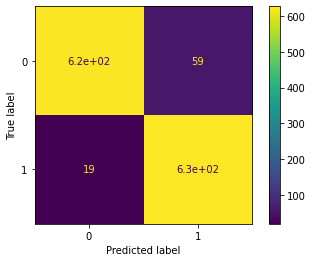

In [ ]:
plot_confusion_matrix(grid_oversample, X_test_oversample, y_test_oversample)  

# UNDERSAMPLE

In [ ]:
## under sampling
"""
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_undersample, y_undersample = undersample.fit_resample(X, y)
"""

"\nundersample = RandomUnderSampler(sampling_strategy='majority')\n# fit and apply the transform\nX_undersample, y_undersample = undersample.fit_resample(X, y)\n"

In [ ]:
#X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=42)

In [ ]:
# defining parameter range 
"""
param_grid_undersample = {'C': [0.1, 1, 10, 100, 1000],  
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                          'kernel': ['rbf']} 

grid_undersample = GridSearchCV(SVC(), param_grid_undersample, refit = True, verbose = 3) 

grid_undersample.fit(X_train_undersample, y_train_undersample) 
"""

"\nparam_grid_undersample = {'C': [0.1, 1, 10, 100, 1000],  \n                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], \n                          'kernel': ['rbf']} \n\ngrid_undersample = GridSearchCV(SVC(), param_grid_undersample, refit = True, verbose = 3) \n\ngrid_undersample.fit(X_train_undersample, y_train_undersample) \n"

In [ ]:
"""
# print best parameter after tuning 
print(grid_undersample.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_undersample.best_estimator_) 
"""

'\n# print best parameter after tuning \nprint(grid_undersample.best_params_) \n  \n# print how our model looks after hyper-parameter tuning \nprint(grid_undersample.best_estimator_) \n'

In [ ]:
#grid_predictions_undersample = grid_undersample.predict(X_test_undersample) 
  
# print classification report 
#print(classification_report(y_test_undersample, grid_predictions_undersample)) 

In [ ]:
#confusion_matrix(y_test_undersample, grid_predictions_undersample)

In [ ]:
#plot_confusion_matrix(grid_undersample, X_test_undersample, y_test_undersample) 